In [5]:
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from scipy.special import softmax
from scipy.stats import pearsonr

In [7]:
import pandas as pd
import re
import string

def remove_emojis(text):
    return ''.join(char for char in text if char in (string.ascii_letters + string.digits + string.punctuation + ' '))

def remove_tags(text):
    return re.sub(r'@\w+', '', text)

def remove_multispace(text):
    return re.sub(r'[\s]+|[\t]|[.,"\']', ' ', text)

def preprocess_pipeline(text):

    text = remove_emojis(text)
    text = remove_tags(text)
    text = remove_multispace(text)

    return text

In [8]:
def results(predictions, true_labels, file_path):
    # metrics: precision, recall, f1-score
    metrics = classification_report(y_true=true_labels, y_pred=predictions)
    # confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Save the heatmap as an image
    plt.savefig(file_path + '_confusion_matrix.png')
    # Serialize and save the dictionary to a file
    with open(file_path + "metrics.json", "w") as file:
        json.dump(metrics, file)

    file.close()


In [9]:
olid = pd.read_csv('data/olid-train-small.csv')
olid['text'] = olid['text'].apply(preprocess_pipeline)

hasoc = pd.read_csv('data/hasoc-train.csv')
hasoc['text'] = hasoc['text'].apply(preprocess_pipeline)

test_data = pd.read_csv('data/olid-test.csv')
test_data['text'] = test_data['text'].apply(preprocess_pipeline)

## training setup from fBert paper:
We used a batch-size of eight, Adam optimiser
with learning rate 1e−4, and a linear learning rate
warm-up over 10% of the training data. During the
training process, the parameters of the transformer
model, as well as the parameters of the subsequent
layers, were updated. The models were trained
using only training data. Furthermore, they were
evaluated while training using an evaluation set that
had one fifth of the rows in training data. We performed early stopping if the evaluation loss did not
improve over ten evaluation steps. All the models
were trained for three epochs.

## cross-domain experiments

In [10]:
# Load your training and evaluation data as pandas DataFrames
eval_fraction = 0.15

# Randomly sample data for evaluation set
eval_data = hasoc.sample(frac=eval_fraction, random_state=42)

# Data not included in the evaluation set is used for training
train_data = hasoc.drop(eval_data.index)

In [11]:
#experimental setup:
model_args = ClassificationArgs()
model_args.train_batch_size = 8
model_args.num_train_epochs = 3
model_args.learning_rate = 1e-4
model_args.warmup_ratio = 0.1
model_args.evaluate_during_training_steps = 20
model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True
model_args.use_early_stopping = True
model_args.early_stopping_patience = 30 #this was increased to 20, not 10 as in fbret paper
#utilities:

model_args.save_eval_checkpoints = False
model_args.overwrite_output_dir = True
model_args.use_multiprocessing=False
model_args.use_multiprocessing_for_evaluation=False

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [12]:
model_args.best_model_dir ='outputs/bert_hasoc'

# Create a ClassificationModel
bert_model_hasoc = ClassificationModel(
    "bert", "bert-base-uncased", args=model_args,
)

# Fine-tune the model
bert_model_hasoc.train_model(train_data, eval_df=eval_data, output_dir='outputs/bert_hasoc')

# Make predictions on new data
#predictions, raw_outputs = model.predict(["Example text 1", "Example text 2"])

# Evaluate the model
bert_model_hasoc_result, bert_model_hasoc_outputs, bert_model_hasoc_wrong_predictions = bert_model_hasoc.eval_model(eval_data)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/622 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/622 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/110 [00:00<?, ?it/s]

In [13]:
model_args.best_model_dir ='outputs/hatebert_hasoc'

# Create a ClassificationModel
hatebert_model_hasoc = ClassificationModel(
    'bert', 'GroNLP/hateBERT', args=model_args
)

# Fine-tune the model
hatebert_model_hasoc.train_model(train_data, eval_df=eval_data, output_dir='output/hatebert_hasoc')

# Make predictions on new data
#predictions, raw_outputs = model.predict(["Example text 1", "Example text 2"])

# Evaluate the model
hatebert_model_hasoc_result, hatebert_model_hasoc_outputs, hatebert_model_hasoc_wrong_predictions = hatebert_model_hasoc.eval_model(eval_data)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/622 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/622 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/622 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/110 [00:00<?, ?it/s]

In [14]:
model_args.best_model_dir ='outputs/fbert_hasoc'

# Create a ClassificationModel
fbert_model_hasoc = ClassificationModel(
    'bert', 'diptanu/fBERT', args=model_args
)

# Fine-tune the model
fbert_model_hasoc.train_model(train_data, eval_df=eval_data, output_dir='output/fbert_hasoc')

# Make predictions on new data
#predictions, raw_outputs = model.predict(["Example text 1", "Example text 2"])

# Evaluate the model
fbert_model_hasoc_result, fbert_model_hasoc_outputs, fbert_model_hasoc_wrong_predictions = fbert_model_hasoc.eval_model(eval_data)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at diptanu/fBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/622 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/622 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/622 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/110 [00:00<?, ?it/s]

### ensemble methods
hard majority voting:

In [15]:
# Load individual pre-trained transformer models
bert_model_hasoc = ClassificationModel("bert", "outputs/bert_hasoc")
hatebert_model_hasoc = ClassificationModel("bert", "outputs/hatebert_hasoc")
fbert_model_hasoc = ClassificationModel("bert", "outputs/fbert_hasoc")

# Make predictions using individual models
bert_hasoc_predictions, bert_model_hasoc_outputs = bert_model_hasoc.predict(test_data["text"].tolist())
hatebert_hasoc_predictions, hatebert_model_hasoc_outputs = hatebert_model_hasoc.predict(test_data["text"].tolist())
fbert_hasoc_predictions, fbert_model_hasoc_outputs = fbert_model_hasoc.predict(test_data["text"].tolist())

# Perform hard majority voting ensemble
hard_majority_predictions = np.array([np.argmax(np.bincount(votes)) for votes in zip(bert_hasoc_predictions,
                                                                                     hatebert_hasoc_predictions,
                                                                                     fbert_hasoc_predictions)])

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

## soft majority voting

In [16]:
# get probabilities from model prediction outputs with softmax:
pr_bert = softmax(bert_model_hasoc_outputs, axis=1)
pr_hatebert = softmax(hatebert_model_hasoc_outputs, axis=1)
pr_fbert = softmax(fbert_model_hasoc_outputs, axis=1)
#get the average of probabilities:
average_probabilities = (pr_bert + pr_hatebert + pr_fbert) / 3
# Get the class index with the highest average probability for each sample
soft_majority_predictions = np.argmax(average_probabilities, axis=1)

### get correlations between transformer models:

In [17]:
# Calculate correlations using scipy's pearsonr function
correlation_bert_hatebert = pearsonr(bert_hasoc_predictions, hatebert_hasoc_predictions)
correlation_bert_fbert = pearsonr(bert_hasoc_predictions, fbert_hasoc_predictions)
correlation_hatebert_fbert = pearsonr(hatebert_hasoc_predictions, fbert_hasoc_predictions)

# putting correlations to dataframe:

In [20]:
dict_correlation_bert_hatebert = {"corr": correlation_bert_hatebert[0],
                                 "p-value":correlation_bert_hatebert[1]}
dict_correlation_bert_fbert = {"corr": correlation_bert_fbert[0],
                                 "p-value":correlation_bert_fbert[1]}
dict_correlation_hatebert_fbert = {"corr": correlation_hatebert_fbert[0],
                                 "p-value":correlation_hatebert_fbert[1]}

corr_indomain_df = pd.DataFrame([dict_correlation_bert_hatebert,dict_correlation_bert_fbert,dict_correlation_hatebert_fbert],
            index=['bert_hatebert','bert_fbert','hatebert_fbert'])

corr_indomain_df
corr_indomain_df.to_csv('results/cross-domain/model_crossdomain_correlations_hard_soft.csv')

### save predictions:

In [21]:
predictions_df = test_data
predictions_df['hard_majority_predictions'] = hard_majority_predictions
predictions_df['soft_majority_predictions'] = soft_majority_predictions
predictions_df.to_csv('results/cross-domain/predictions_crossdomain_hard_soft.csv')

### get classification report and confussion matrix

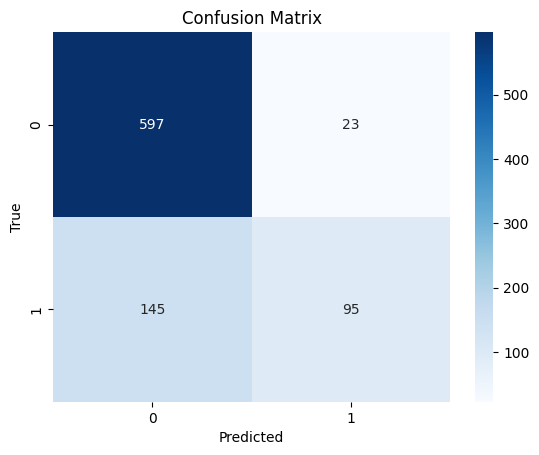

In [22]:
results(hard_majority_predictions, test_data['labels'], file_path='results/cross-domain/hard majority voting/hard_majority_results')

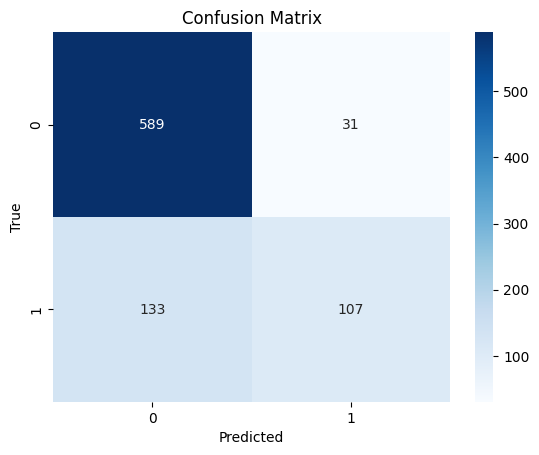

In [24]:
results(soft_majority_predictions, test_data['labels'], file_path='results/cross-domain/soft majority voting/soft_majority_results')